# Monitoring RL agent with probabilistic guarantees
## Case study: GridWorld
_______________________________

**Dependencies:**
- julia 0.6
- python 3.6 (anaconda distribution)
- [Storm](http://www.stormchecker.org/) 


In [1]:
using MDPModelChecking, POMDPs, POMDPToolbox, POMDPModels
using DiscreteValueIteration, TabularTDLearning
using PyPlot

In [2]:
rng = MersenneTwister(1)

MersenneTwister(UInt32[0x00000001], Base.dSFMT.DSFMT_state(Int32[1749029653, 1072851681, 1610647787, 1072862326, 1841712345, 1073426746, -198061126, 1073322060, -156153802, 1073567984  …  1977574422, 1073209915, 278919868, 1072835605, 1290372147, 18858467, 1815133874, -1716870370, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 382)

In [3]:
include("plot_helpers.jl")

### Problem Definition

In Grid World, we are trying to control an agent who has trouble moving in the desired direction. In our problem, we have a four reward states on a $10\times 10$ grid. Each position on the grid represents a state, and the positive reward states are terminal (the agent stops recieveing reward after reaching them). 

The agent has four actions to choose from: up, down, left, right. The agent moves in the desired direction with a probability of 0.7, and with a probability of 0.1 in each of the remaining three directions. 

The model is provided by the package [POMDPModels.jl](https://github.com/JuliaPOMDP/POMDPModels.jl)


#### Load Problem 

In [46]:
mdp = GridWorld(sx=10,sy=10)
mdp.reward_states = [GridWorldState(4, 3), GridWorldState(4, 6), GridWorldState(9, 3)]
mdp.reward_values = [-200, -200, 10.0]
mdp.terminals = Set(mdp.reward_states)
mdp.bounds_penalty = 0.;

In [47]:
function POMDPs.initialstate_distribution(mdp::GridWorld)
    states = [GridWorldState(1, y) for y=1:mdp.size_y]
    return SparseCat(states, 1/length(states)*ones(length(states)))
end

function POMDPs.initialstate(mdp::GridWorld, rng::AbstractRNG)
    y = rand(rng, 1:mdp.size_y)
    return GridWorldState(1, y)
end

# function POMDPs.initialstate_distribution(mdp::GridWorld)
#     return SparseCat(states(mdp), normalize(ones(n_states(mdp)), 1))
# end

In [48]:
# any of the corners
# POMDPs.initialstate(mdp::GridWorld, rng::AbstractRNG) = GridWorldState(1, mdp.size_y)

**Representation of the Grid World**

There are two "bad states" in red and two "good states" in green

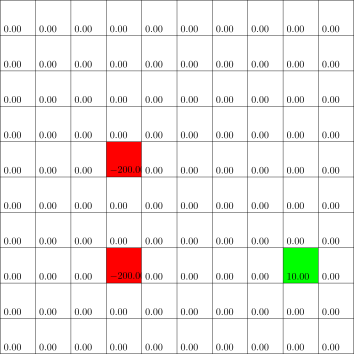

In [49]:
POMDPModels.plot(mdp, s->static_reward(mdp, s))

### Model checking approach

Instead of optimizing the reward function using conventional approach, we would like to find a policy verifying some safety guarantee. 

More precisely we would like our agent to avoid the bad states with 99% confidence. This specification can be expressed using a temporal logic formula:
$$
 \phi = \neg \verb|bad| \text{ U } \verb|good|
$$

We will use tools from the storm model checking library to compute the maximum probability of satisfying this formula:
$$
\Pr (s \models \phi) 
$$

**Convert the problem from POMDPs.jl to Storm input**

Write the transition probabilities to storm explicit format as follows: 
```
mdp
0 0 1 0.3
0 0 4 0.7
0 1 0 0.5
0 1 1 0.5
1 0 1 1.0
...
```

In our usual MDP formulation a row is: $s, a, s', T(s,a,s')$

**/!\ Storm back end uses python, It is 0-indexed!**



write the transition to a file

In [50]:
write_mdp_transition(mdp, "grid_world.tra")

**Label the MDP states**

File format:
Define labels and write the mapping from states to labels in a file using the following syntax: 
```
#DECLARATION
label1, label2, label3
#END
0 label1 label2
15 label2
23 label3
```

All the possible labels must be declared first. A state can have several labels. In the file the states must be ordered.
(the function to write the file is implemented in `pomdps_to_storm.jl`)

In [51]:
# return a dictionary mapping states to label
# the positive reward states are labeled as good 
# the negative reward states are labeled as bad
function label_grid_world(mdp::GridWorld)
    good_states = mdp.reward_states[mdp.reward_values .> 0.]
    bad_states = mdp.reward_states[mdp.reward_values .< 0.]
    labeling = Dict{state_type(mdp), Vector{String}}()
#     for s in good_states
#         labeling[s] = ["good"]
#     end
    for s in bad_states
        labeling[s] = ["bad"]
    end
    labeling[GridWorldState(0, 0, true)] = ["good", "term"]
    return labeling
end

function label_initialstates!{S,A}(mdp::MDP{S, A}, init_states::Vector{S}, labeling::Dict{S, String})
    for s in init_states
        if haskey(labeling, s)
            push!(labeling[s],"init")
        else
            labeling[s] = ["init"]
        end
    end
end

label_initialstates! (generic function with 1 method)

In [52]:
labeling = label_grid_world(mdp)
# label_initialstates!(mdp, states(mdp), labeling)

Dict{POMDPModels.GridWorldState,Array{String,1}} with 3 entries:
  POMDPModels.GridWorldState(4, 6, false) => String["bad"]
  POMDPModels.GridWorldState(4, 3, false) => String["bad"]
  POMDPModels.GridWorldState(0, 0, true)  => String["good", "term"]

Write the labels to a file

In [53]:
write_mdp_labels(mdp, labeling, "grid_world.lab")

## Define Specification and run the model checker

This is the property to verify, it is expressed as a LTL formula over the labels.

In [54]:
# property = "Pmax=? [ (!\"bad\") U \"good\"]" 
# property = "Pmax=? [ (! \"bad\" U \"good\") & (F \"good\")]" 
# property = "Pmax=? [ F \"good\"]"
property = "Pmax=? [ G ! \"bad\"]"
# property = "multi(Pmax=? [! \"bad\" U \"good\" ], Pmax=? [ F \"good\" ])"
# property = "Pmax=? [ F \"crash\" ]"

"Pmax=? [ G ! \"bad\"]"

In [55]:
threshold = 0.99;

In [56]:
@time result = model_checking(mdp, labeling, property, transition_file_name="grid_world.tra", labels_file_name="mdp.lab"); 

  0.003998 seconds (162 allocations: 5.711 KiB)


### Extract the possible safe policies

The result from the storm model checking returned the controller that maximizes the probability of satisfying our specification. In practice, we just want to ensure that the probability stays above a desired threshold.

We split the state space into two parts:
- the red states represent states where the probability of statisfying $\phi$ is below the desired threshold
- the green states if it is above

The arrows represent the possible actions available at each state. 

In the red zone, only the controller maximizing satisfaction can be applied. In the green zone, the possible actions are computed by a "one step lookahead". We compute the function $P_{\phi}(s, a)$ the probability of satisfying $\phi$ when starting by taking action $a$ in state $s$: 
$$
P_{\phi}(s, a) = \sum_{s'\in \mathcal{S}} \Pr(s'\mid s, a)\Pr(s' \models \phi)
$$

By thresholding $P_{\phi}(s, a)$ for each action we have the set of available actions.

In [57]:
P = get_proba(mdp, result)
p0 = initial_probability(mdp, result)
println("The lowest probability of success is ", minimum(P), " for initial state ", states(mdp)[indmin(P)])
println("The average probability of success is ", p0)

The lowest probability of success is 0.0 for initial state POMDPModels.GridWorldState(4, 3, false)
The average probability of success is 0.9999999999999999


In [58]:
norm(P)

9.82368889255027

In [70]:
s = GridWorldState(3,2)
si = stateindex(mdp, s)
P[si]

0.9778123118933125

In [73]:
norm(round.(P, 1))

9.873196037757987

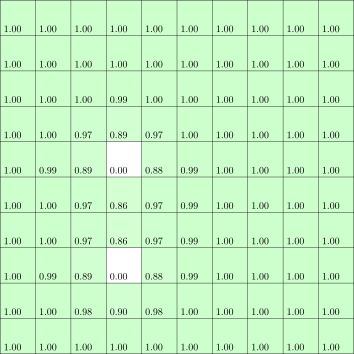

In [64]:
POMDPModels.plot(mdp, P)

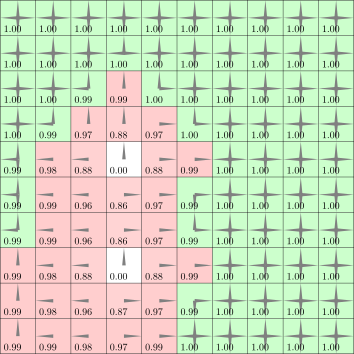

In [18]:
safe_policy = Scheduler(mdp, result) # not possible for every formula
mask = SafetyMask(mdp, result, threshold)
POMDPModels.plot(mdp, P, mask, threshold = threshold)

In [17]:
random_masked_policy = MaskedEpsGreedyPolicy(mdp, 0.9, mask, rng);

### Monitor a Q-learning agent

Use tabular Q learning to optimize the reward function while constraining the agent to choose actions in the safety mask above. 

In [25]:
solver = QLearningSolver(mdp, 
                         n_episodes=20000, 
                         learning_rate = 0.01, 
                         exp_policy = MaskedEpsGreedyPolicy(mdp, 0.5, mask, MersenneTwister(1)), 
                         rng=MersenneTwister(1),
                         n_eval_traj = 100,
                         log_eval = true)
masked_ql_training_perf = solver.r_log
masked_policy = solve(solver, mdp, MaskedValuePolicy(solver.exploration_policy.val, mask), verbose=false)

POMDPStorm.MaskedValuePolicy{POMDPStorm.SafetyMask{POMDPModels.GridWorld,Symbol}}(POMDPToolbox.ValuePolicy{Symbol,POMDPModels.GridWorld}(POMDPModels.GridWorld(10, 10, POMDPModels.GridWorldState[POMDPModels.GridWorldState(4, 3, false), POMDPModels.GridWorldState(4, 6, false), POMDPModels.GridWorldState(9, 3, false)], [-200.0, -200.0, 10.0], 0.0, 0.7, Set(POMDPModels.GridWorldState[POMDPModels.GridWorldState(4, 6, false), POMDPModels.GridWorldState(4, 3, false), POMDPModels.GridWorldState(9, 3, false)]), 0.95), [1.26441 0.0 0.0 0.0; 1.05283e-50 0.0 1.06752 0.0; … ; 4.00877 5.12668 4.20286 3.85087; 0.0 0.0 0.0 0.0], Symbol[:up, :down, :left, :right]), POMDPStorm.SafetyMask{POMDPModels.GridWorld,Symbol}(POMDPModels.GridWorld(10, 10, POMDPModels.GridWorldState[POMDPModels.GridWorldState(4, 3, false), POMDPModels.GridWorldState(4, 6, false), POMDPModels.GridWorldState(9, 3, false)], [-200.0, -200.0, 10.0], 0.0, 0.7, Set(POMDPModels.GridWorldState[POMDPModels.GridWorldState(4, 6, false), POMD

Visualize the resulting policy and the value function. We can notice that the agent did not receive any negative feedback during training and the bad states have the value 0 rather than their associated penalty. **This value table is valid only in the states where the probability of satisfying the specification is above the threshold**.

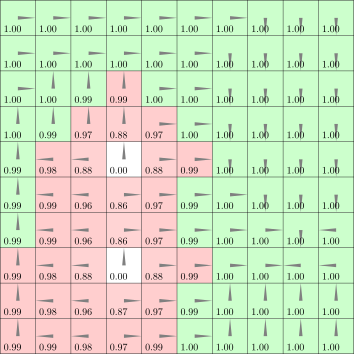

In [26]:
# Resulting policy from optimizing in the constrained environment
POMDPModels.plot(mdp, P, masked_policy, threshold=threshold)

### Compare with Reward based approach

We will compare the approach with a reward based approach. Can we get the same results by increasing the cost of visiting the bad states?

In [27]:
solver = QLearningSolver(mdp, 
                         n_episodes=20000, 
                         learning_rate = 0.01, 
                         exp_policy = EpsGreedyPolicy(mdp, 0.5, rng=MersenneTwister(1)),
                         rng = MersenneTwister(1),
                         n_eval_traj = 100,
                         log_eval = true)
@time ql_policy = solve(solver, mdp, verbose=false);
# ql_training_perf = solver.r_log;

  9.928451 seconds (103.24 M allocations: 5.419 GiB, 14.12% gc time)


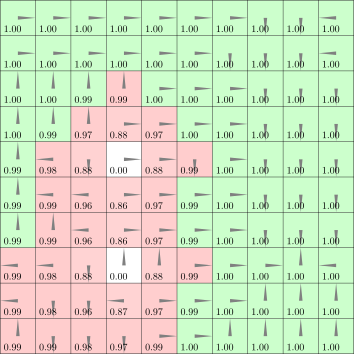

In [28]:
p = POMDPModels.plot(mdp, P, ql_policy, threshold=threshold)

### Convergence properties

In [29]:
PyPlot.plot(masked_ql_training_perf, color = "b")
PyPlot.plot(ql_training_perf, color = "orange")

LoadError: [91mUndefVarError: ql_training_perf not defined[39m

### Compare policies

In [30]:
# any of the corners
# POMDPs.initialstate(mdp::GridWorld, rng::AbstractRNG) = rand(rng, states(mdp)[P .> 0.98])

In [31]:
n_ep = 10000
max_steps = 200
pol1 = ql_policy
pol2 = masked_policy
rewards1 = zeros(n_ep)
steps1 = zeros(n_ep)
hist1 = Vector{Any}(n_ep)
rewards2 = zeros(n_ep)
steps2 = zeros(n_ep)
hist2 = Vector{Any}(n_ep)
for ep=1:n_ep
    s0 = initialstate(mdp, rng)
    hr1 = HistoryRecorder(max_steps=max_steps, rng=rng)
    hist1 = simulate(hr1, mdp, pol1, s0)
    hr2 = HistoryRecorder(max_steps=max_steps, rng=rng)
    hist2 = simulate(hr2, mdp, pol2, s0)
    rewards1[ep] = undiscounted_reward(hist1)
    rewards2[ep] = undiscounted_reward(hist2)
    steps1[ep] = n_steps(hist1)
    steps2[ep] = n_steps(hist2)
end

violations1 = sum(rewards1 .< 0.) #+ sum(steps1 .>= max_steps)
violations2 = sum(rewards2 .< 0.) #+ sum(steps2 .>= max_steps)
time_outs1 = sum(steps1 .>= max_steps)
time_outs2 = sum(steps2 .>= max_steps)

0

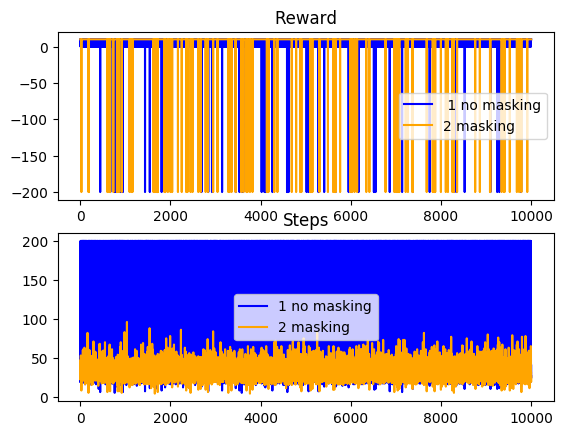

Mean Reward in 1: 5.67
Mean Reward in 2: 7.648
Mean Steps in 1: 84.9988
Mean Steps in 2: 32.4833
% of violations in 1: 0.51
% of violations in 2: 1.1199999999999999
time outs 1: 3259
time outs 2: 0




PyObject Text(0.5,1,'Steps')

In [32]:
println("Mean Reward in 1: ", mean(rewards1))
println("Mean Reward in 2: ", mean(rewards2))
println("Mean Steps in 1: ", mean(steps1))
println("Mean Steps in 2: ", mean(steps2))
println("% of violations in 1: ", violations1/n_ep*100)
println("% of violations in 2: ", violations2/n_ep*100)
println("time outs 1: ", time_outs1)
println("time outs 2: ", time_outs2)
println("\n")


fig, axes = PyPlot.subplots(2, 1)
p1 = axes[1][:plot](rewards1, color="blue")
p2 = axes[1][:plot](rewards2, color="orange")
axes[1,1][:legend]([" 1 no masking", "2 masking"])
axes[1][:set_title]("Reward")


p1 = axes[2][:plot](steps1, color="blue")
p2 = axes[2][:plot](steps2, color="orange")
axes[2][:legend](["1 no masking", "2 masking"])
axes[2][:set_title]("Steps")


## Value Iteration

In [40]:
function POMDPs.actions(mdp::GridWorld, s::GridWorldState)
    return actions(mdp)
end
solver = ValueIterationSolver(max_iterations=1000)
vi_policy1 = solve(solver, mdp);

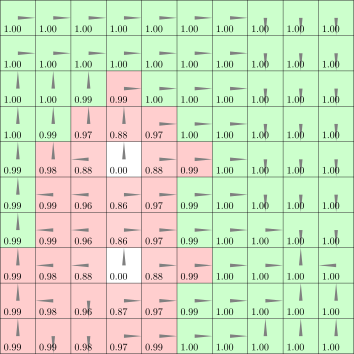

In [41]:
POMDPModels.plot(mdp, P, vi_policy1, threshold=threshold)

In [50]:
function POMDPs.actions(mdp::GridWorld, s::GridWorldState)
    return safe_actions(mask, s)
end

solver = ValueIterationSolver(max_iterations=100)
vi_pol2 = solve(solver, mdp);
val = ValuePolicy(mdp)
val.value_table = vi_pol2.qmat
vi_policy2 = MaskedValuePolicy(val, mask);

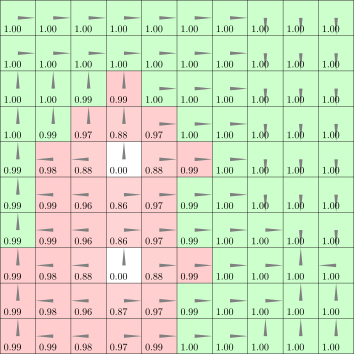

In [51]:
POMDPModels.plot(mdp, P, vi_policy2, threshold=threshold)

In [52]:
n_ep = 10000
max_steps = 200
pol1 = vi_policy1
pol2 = vi_policy2
rewards1 = zeros(n_ep)
steps1 = zeros(n_ep)
hist1 = Vector{Any}(n_ep)
rewards2 = zeros(n_ep)
steps2 = zeros(n_ep)
hist2 = Vector{Any}(n_ep)
for ep=1:n_ep
    s0 = initialstate(mdp, rng)
    hr1 = HistoryRecorder(max_steps=max_steps, rng=rng)
    hist1 = simulate(hr1, mdp, pol1, s0)
    hr2 = HistoryRecorder(max_steps=max_steps, rng=rng)
    hist2 = simulate(hr2, mdp, pol2, s0)
    rewards1[ep] = undiscounted_reward(hist1)
    rewards2[ep] = undiscounted_reward(hist2)
    steps1[ep] = n_steps(hist1)
    steps2[ep] = n_steps(hist2)
end

violations1 = sum(rewards1 .< 0.) #+ sum(steps1 .>= max_steps)
violations2 = sum(rewards2 .< 0.) #+ sum(steps2 .>= max_steps)
time_outs1 = sum(steps1 .>= max_steps)
time_outs2 = sum(steps2 .>= max_steps)

println("Mean Reward in 1: ", mean(rewards1))
println("Mean Reward in 2: ", mean(rewards2))
println("Mean Steps in 1: ", mean(steps1))
println("Mean Steps in 2: ", mean(steps2))
println("% of violations in 1: ", violations1/n_ep*100)
println("% of violations in 2: ", violations2/n_ep*100)
println("time outs 1: ", time_outs1)
println("time outs 2: ", time_outs2)
println("\n")

Mean Reward in 1: 7.586
Mean Reward in 2: 8.425
Mean Steps in 1: 41.0647
Mean Steps in 2: 32.7522
% of violations in 1: 0.8699999999999999
% of violations in 2: 0.75
time outs 1: 587
time outs 2: 0




## Pareto fronts

In [53]:
function evaluation_loop(mdp::MDP, policy::Policy; n_ep::Int64 = 1000, max_steps::Int64 = 500, rng::AbstractRNG = Base.GLOBAL_RNG)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    violations = zeros(n_ep)
    for ep=1:n_ep
        s0 = initialstate(mdp, rng)
        hr = HistoryRecorder(max_steps=max_steps, rng=rng)
        hist = simulate(hr, mdp, policy, s0)
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
        violations[ep] = sum(hist.reward_hist .< 0.) #+ Int(n_steps(hist) >= max_steps)
    end
    return rewards, steps, violations
end

evaluation_loop (generic function with 1 method)

In [54]:
function get_operating_points(mdp::MDP, bad_states_reward::Vector{Float64}; n_ep = 10000, masking=false, mask::SafetyMask=mask)
    avg_reward = zeros(length(bad_states_reward))
    avg_steps = zeros(length(bad_states_reward))
    avg_violations = zeros(length(bad_states_reward))
    solver = ValueIterationSolver(max_iterations=1000)
    for (i, r) in enumerate(bad_states_reward)
        mdp.reward_values[1:2] = r 
        vi_pol = solve(solver, mdp);
        if masking
            val = ValuePolicy(mdp)
            val.value_table = vi_pol.qmat
            vi_pol = MaskedValuePolicy(val, mask)
        end
        rewards, steps, violations = evaluation_loop(mdp, vi_pol, n_ep=n_ep)
        avg_reward[i] = mean(rewards)
        avg_steps[i] = mean(steps)
        avg_violations[i] = sum(violations)/n_ep*100
    end
    return avg_reward, avg_steps, avg_violations
end

get_operating_points (generic function with 1 method)

In [57]:
bad_states_reward = [-1, -10., -50., -100., -200, -300]
# activate mask
function POMDPs.actions(mdp::GridWorld, s::GridWorldState)
    return safe_actions(mask, s)
end
mask = SafetyMask(mdp, result, threshold)
mask_r, mask_s, mask_v= get_operating_points(mdp, bad_states_reward, n_ep=100000, masking=true, mask=mask)

# deactivate mask
function POMDPs.actions(mdp::GridWorld, s::GridWorldState)
    return actions(mdp)
end
nomask_r, nomask_s, nomask_v= get_operating_points(mdp, bad_states_reward, n_ep=100000, masking=false, mask=mask)


([3.45421, 3.10355, 2.46125, 1.97945, 1.26134, 1.01626], [18.8773, 22.8041, 25.1158, 26.2935, 57.3393, 184.233], [10.581, 3.158, 2.013, 1.617, 0.813, 0.403])

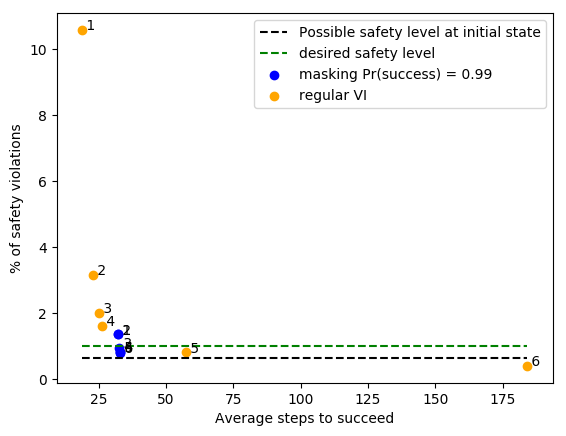

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f91abe98e10>

In [59]:
fig, ax = PyPlot.subplots(1)
ax[:plot](nomask_s, 100*(1-p0)*ones(length(mask_s)), color="black", linestyle="dashed")
ax[:plot](nomask_s, 100*(1-threshold)*ones(length(mask_s)), color="green", linestyle="dashed")
ax[:scatter](mask_s, mask_v, color="blue")
for i=1:length(mask_s)
    ax[:annotate](@sprintf(" %i", i),
              xy=[mask_s[i]; mask_v[i]+0.001],
              xycoords="data")
end
ax[:scatter](nomask_s, nomask_v, color="orange")
for i=1:length(nomask_s)
    ax[:annotate](@sprintf(" %i", i),
              xy=[nomask_s[i]; nomask_v[i]+0.001],
              xycoords="data")
end
ax[:set_ylabel]("% of safety violations")
ax[:set_xlabel]("Average steps to succeed")
# ax[:set_xlim](8, 33)
# ax[:set_ylim](-0.001, 0.01)
ax[:legend](["Possible safety level at initial state", "desired safety level", "masking Pr(success) = $threshold", "regular VI"])
ax

In [49]:
fig, ax = PyPlot.subplots(1)
ax[:plot](bad_states_reward, nomask_r)
ax[:plot](bad_states_reward, mask_r, color="orange")
ax[:set_xlabel]("collision cost")
ax[:set_ylabel]("Average reward")
ax[:legend](["No masking", "Masking"])

LoadError: [91mUndefVarError: nomask_r not defined[39m

## Profiling

In [1]:
using POMDPs, POMDPModels, DiscreteValueIteration
using ProfileView

In [15]:
Profile.clear()

In [20]:
gw = GridWorld()
solver = ValueIterationSolver()
@profile for i=1:1000; policy = solve(solver, gw); end

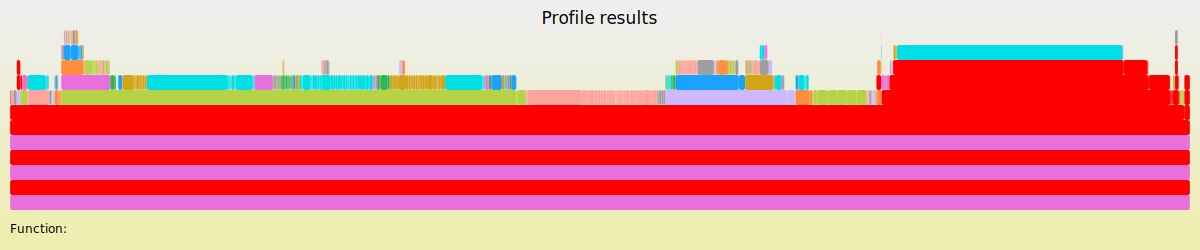

In [21]:
ProfileView.view()